### Part 1: Test Plotting Raw Data From ArchViewer

Step 1: Start by looking at the data for a small timeframe using the PV "SOLN:GUNB:100"
- test 1 minute vs 5 minutes vs 15 minutes to see if there are timeframe gaps or if all the data is actually saved

Step 2: Clean the data if necessary, save in a function

Step 3: Visualize with matplotlib, save in a function

Step 4: Develop a filtering function that only analyzes the peaks and returns timestamps for the max and the width of the peak

In [4]:
import numpy as np
import pandas as pd

In [41]:
# get average length of non-NA data points of each 1m interval for the 1m, 1h, and 1d csv files 

soln_gunb_100_df_1m = pd.read_csv("1m-soln-gunb-100.csv")
soln_gunb_100_df_5m = pd.read_csv("5m-soln-gunb-100.csv")
soln_gunb_100_df_15m = pd.read_csv("15m-soln-gunb-100.csv")

"""for a df, for every column, get its length, ignoring the NA cells, and return the average length""" 
def get_length_avg_no_NA(df_name): 
    col_sum = 0
    for column_name in df_name: 
        col_length = len(df_name[column_name].dropna())
        col_sum += col_length
    return col_sum / len(df_name.columns)

# return values

print(f"Length of 1m column: {get_length_avg_no_NA(soln_gunb_100_df_1m)}")
print(f"Length of 5m column: {get_length_avg_no_NA(soln_gunb_100_df_5m)}")
print(f"Length of 15m column: {get_length_avg_no_NA(soln_gunb_100_df_15m)}")

Length of 1m column: 10.525
Length of 5m column: 40.975
Length of 15m column: 231.2


In conclusion, this roughly scales linearly, so it's not like the ArchViewer is hiding data for larger timestamps. 

It was discovered that when you save data, a good chunk of it is taken from a completely different day. So the best way to deal with this issue is to get the first several characters, get the most common date (since we only care about a single day), and filter out the undesired rows. 

In [83]:
# test filtering out irrelevant dates using the 1m df 

soln_gunb_100_df_1m["Timestamp"][0][0:10]

test_timestamp_list = soln_gunb_100_df_1m["Timestamp"].tolist()
date_only_list = [x[0:10] for x in test_timestamp_list] # list with only dates

from collections import Counter
date_counts_dict = Counter(date_only_list)
common_date = date_counts_dict.most_common(1)[0][0] # get the most common date

# only get rows that have the common date 

common_date_only_list = [x if x == common_date else None for x in date_only_list]
none_length = len([x for x in common_date_only_list if x == None])
filtered_soln_gunb_100_df_1m = soln_gunb_100_df_1m.iloc[none_length:, 0:]

filtered_soln_gunb_100_df_1m.head(3)

,Timestamp,SOLN:GUNB:100:ACCESS,SOLN:GUNB:100:BACT,SOLN:GUNB:100:BCON,SOLN:GUNB:100:BCTRL,SOLN:GUNB:100:BDES,SOLN:GUNB:100:BLEM,SOLN:GUNB:100:BMAGX,SOLN:GUNB:100:BMAGY,SOLN:GUNB:100:BMOD,...,SOLN:GUNB:100:PTRBDISABLE,SOLN:GUNB:100:RAMPSTATE,SOLN:GUNB:100:STATE,SOLN:GUNB:100:STATESETPT,SOLN:GUNB:100:STATMSG,SOLN:GUNB:100:STDZDISABLE,SOLN:GUNB:100:STDZOK,SOLN:GUNB:100:TRIMDISABLE,SOLN:GUNB:100:TRIMIFINTOL,SOLN:GUNB:100:UNAVAIL
16,2024/06/18 12:32:44.647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2024/06/18 12:32:44.648,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2024/06/18 12:32:45.643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Part 2: Data Cleaning Functions

Now that we have strategies for data cleaning, we can consolidate these approaches of: 
- getting data from a column
- removing NaN rows
- removing irrelevant dates

In [196]:
from collections import Counter

"""Returns the ratio of normal elements to total cells"""
def get_non_na_ratio(df_name, col_name): 
    tot_len = len(df_name[col_name])
    na_len = tot_len - len(df_name[col_name].dropna())
    return (tot_len - na_len) / tot_len

"""Returns a df with irrelevant rows removed"""
def remove_irrelevant_dates(df_name): 
    test_timestamp_list = df_name["Timestamp"].tolist()
    date_only_list = [x[0:10] for x in test_timestamp_list] # list with only dates

    date_counts_dict = Counter(date_only_list)
    common_date = date_counts_dict.most_common(1)[0][0] # get the most common date

    # only get rows that have the common date 

    common_date_only_list = [x if x == common_date else None for x in date_only_list]
    none_length = len([x for x in common_date_only_list if x == None])
    filtered_df = df_name.iloc[none_length:, 0:]
    return filtered_df

"""Returns a df with a single column without NA values"""
def remove_nan_from_col(df_name, col_name): 
    new_df = df_name[pd.notna(df_name[col_name])]
    return new_df[["Timestamp", col_name]]

"""Returns a df without the date and hour in the Timestamp"""
def remove_date(df_name): 
    timestamps = df_name["Timestamp"]
    result_timestamps = [x[14:] for x in timestamps]
    result_df = df_name.copy()
    result_df["Timestamp"] = result_timestamps
    return result_df

Now, we can plot any column we like. Below is a test plot of "SOLN:GUNB:100:BACT." This will then be summarized in functions and repurposed to generate an altogether plot of all the interesting data. 

Normal element to total ratio: 0.3612662942271881


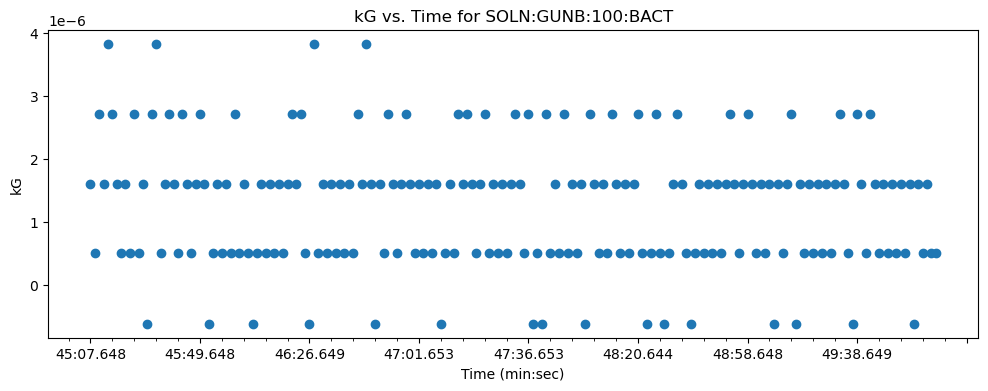

In [197]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 4))

# get normal/total ratio
print(f"Normal element to total ratio: {get_non_na_ratio(soln_gunb_100_df_5m, "SOLN:GUNB:100:BACT")}")
# remove irrelevant rows
soln_gunb_100_df_5m_rows = remove_irrelevant_dates(soln_gunb_100_df_5m)
# remove unwanted columns
soln_gunb_100_df_5m_cols = remove_nan_from_col(soln_gunb_100_df_5m_rows, "SOLN:GUNB:100:BACT")
# modify timestamp text to only include the hour, min, and sec
soln_gunb_100_df_5m_plot = remove_date(soln_gunb_100_df_5m_cols)

ax.scatter(soln_gunb_100_df_5m_plot["Timestamp"], soln_gunb_100_df_5m_plot["SOLN:GUNB:100:BACT"])

# x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
ax.set_xlabel("Time (min:sec)")
ax.set_ylabel("kG")
ax.set_title("kG vs. Time for SOLN:GUNB:100:BACT")

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

### Part 3: Defining Plotting Functions  

These functions work on csvs that were downloaded, imported, and converted to DataFrames from the Archive Viewer website. 

1. `specific_col_plot` Plot of a specific column
2. `megaplot_all_cols` Megaplot of all the columns from the dataframe
3. `megaplot_spec_cols` Megaplot of a specified list of columns from the dataframe
4. `spec_correl` Plot of a specific correlation between two specific dataframes and their specified columns
5. `correl_all_x` Megaplot of a correlation between a specific dataframe's column (y-axis) and all the columns of another dataframe (x-axis)
6. `correl_all_y` Megaplot of a correlation between a specific dataframe's column (x-axis) and all the columns of another dataframe (y-axis)
7. `get_nan_ratio` Returns the value to NaN ratio in a column

In [245]:
"""Plot of a specific column in a df"""
def specific_col_plot(df_name, col_name, y_axis_title): 
    fig, ax = plt.subplots(figsize=(12, 4))
    # get normal/total ratio
    print(f"Normal element to total ratio: {get_non_na_ratio(df_name, col_name)}")
    # remove irrelevant rows
    df_rows = remove_irrelevant_dates(df_name)
    # remove unwanted columns
    df_cols = remove_nan_from_col(df_rows, col_name)
    # modify timestamp text to only include the hour, min, and sec
    df_plot = remove_date(df_cols)

    ax.scatter(df_plot["Timestamp"], df_plot[col_name])

    # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
    ax.set_xlabel("Time (min:sec)")
    ax.set_ylabel(y_axis_title)
    ax.set_title(f"{y_axis_title} vs. Time for {col_name}")

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

"""Megaplot of all the columns from the df"""
def megaplot_all_cols(df_name, y_axis_title): 
    # want to create a grid of subplots
    col_len = len(df_name.columns) - 1
    dim = int(np.sqrt(col_len))
    fig, ax = plt.subplots(dim, dim, figsize=(17, 12))
    col_ind = 1
    for i in range(0, dim): 
        for j in range(0, dim): 
            # remove irrelevant rows
            df_rows = remove_irrelevant_dates(df_name)
            # remove unwanted columns
            df_cols = remove_nan_from_col(df_rows, df_rows.columns[col_ind])
            # modify timestamp text to only include the hour, min, and sec
            df_plot = remove_date(df_cols)

            ax[i, j].scatter(df_plot["Timestamp"], df_plot[df_name.columns[col_ind]], s=10)
            ax[i, j].xaxis.set_major_locator(ticker.LinearLocator(3))
            ax[i, j].xaxis.set_minor_locator(ticker.LinearLocator(0))
            ax[i, j].tick_params(axis='y', which='major', labelsize=8)
            ax[i, j].tick_params(axis='x', which='major', labelsize=8)
            ax[i, j].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

            # x label is always in seconds, but y label must be specified by the user as it is not given in the csv file
            ax[i, j].set_xlabel("Time (min:sec)")
            ax[i, j].set_ylabel(y_axis_title)
            ax[i, j].set_title(f"{y_axis_title} vs. Time for {df_name.columns[col_ind]}", {'fontsize': 7})

            col_ind += 1 # keep track of which column is being plotted

### Part 4: Isolating Peaks

For some PVs, rather than continual, steady oscillation, there are clear peaks in data points. We want to isolate these and only return those data points before plotting these columns and their correlations. 

### Part 5: Example Plots

The following plots are simple tests, and more can be generated as needed when testing the visual viewer's results in comparison to what can be achieved with MEME or the archive script from lcls-tools.

Normal element to total ratio: 0.392


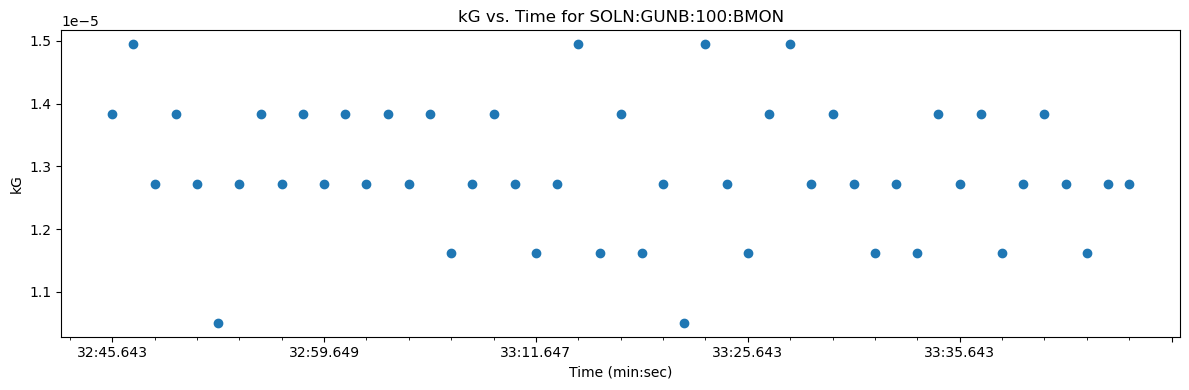

In [247]:
specific_col_plot(soln_gunb_100_df_1m, "SOLN:GUNB:100:BMON", "kG")

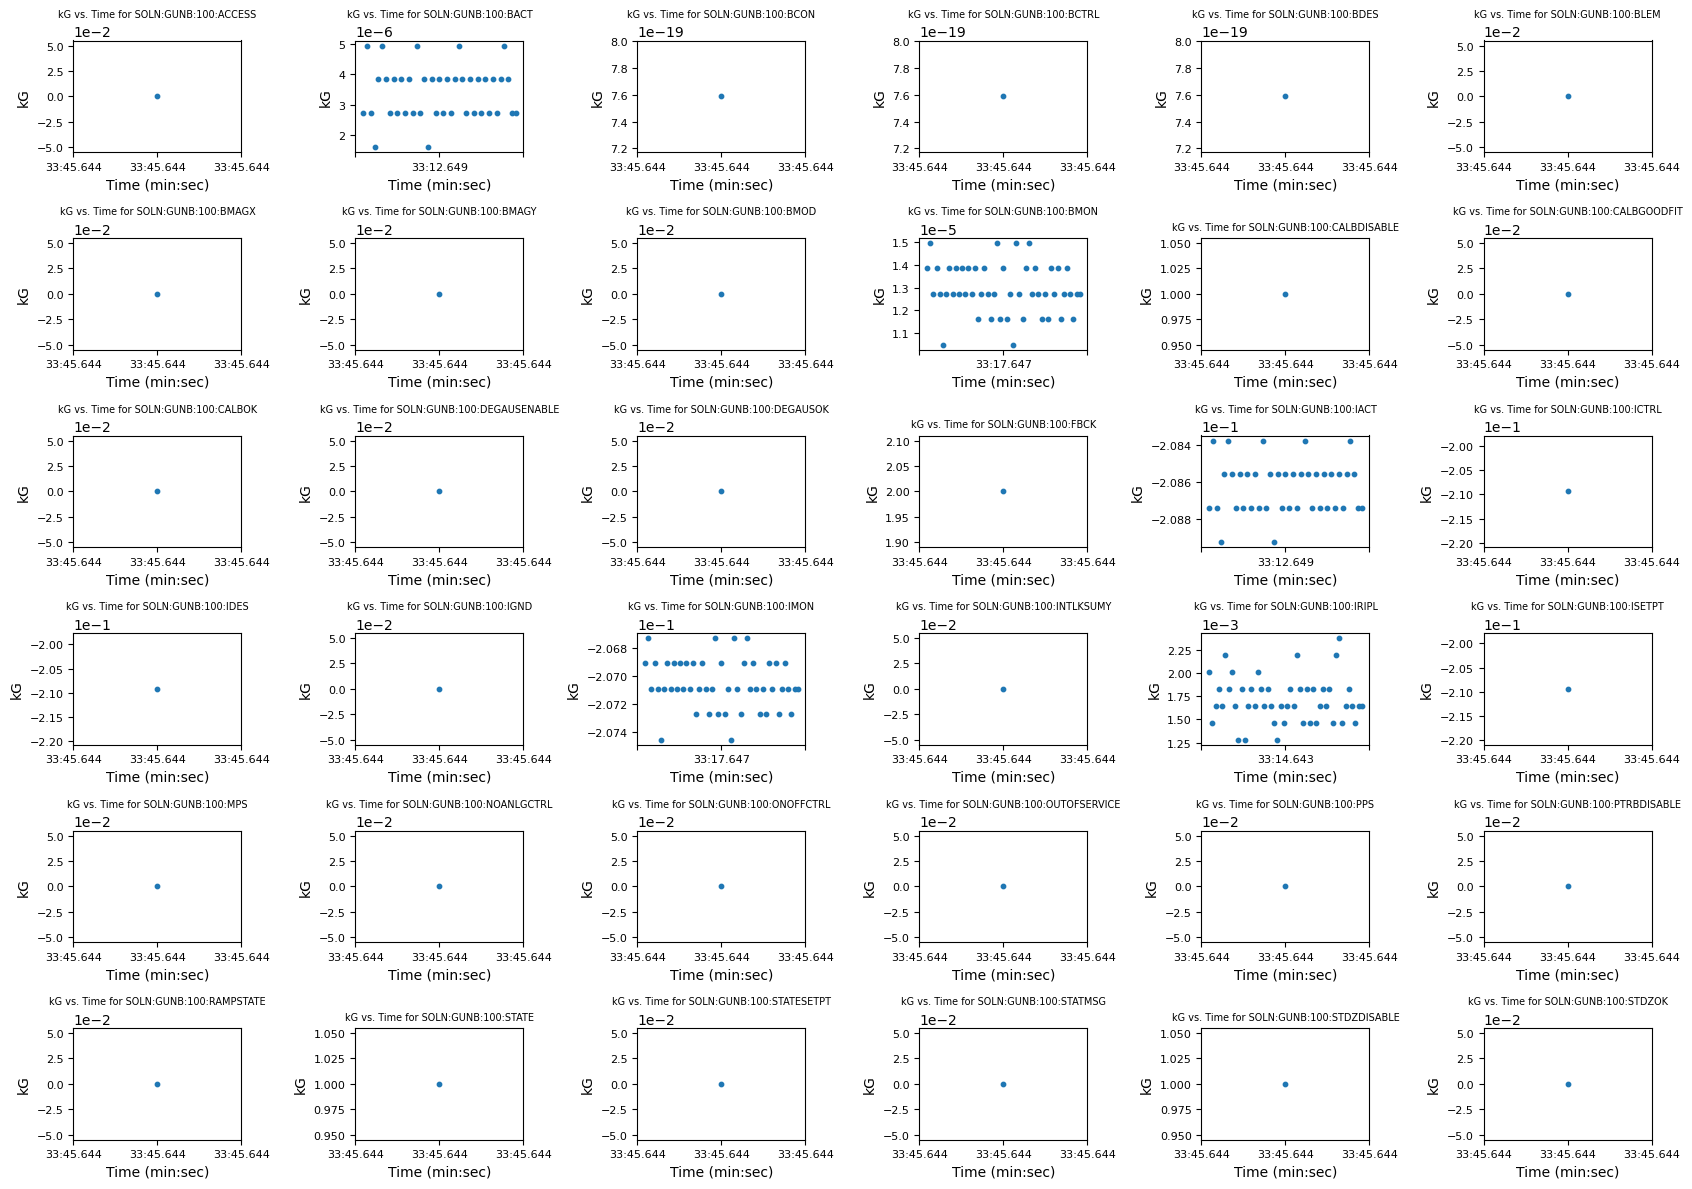

In [246]:
megaplot_all_cols(soln_gunb_100_df_1m, "kG")

### Next Steps

Although now we have useful functions that can be used to draw correlations between different components along the beamline, it is still cumbersome to go to the visual tool, click on several buttons, download the files, convert them to dataframes, and then feed them into functions. 

A future extension can be to write a selenium python bot to automatically search for a PV, select a timeframe, download the file, and convert it to a dataframe. This can then be applied to the various other existing functions. 